In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/My Drive/data/'
BUFFER_SIZE = 50
BATCH_SIZE  = 1
IMG_WIDTH   = 1024
IMG_HEIGHT  = 256

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))    
    
    # make input
    lr = tf.identity(image)
    lr = tf.image.resize(lr, (IMG_HEIGHT//4, IMG_WIDTH//4))

    return lr, image

(64, 256, 3)
(256, 1024, 3)


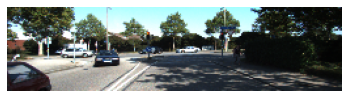

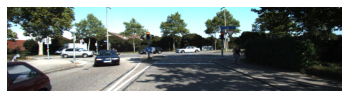

In [ ]:
lr, image = load(PATH+'unet/kitti_train/000008_10.png')
print(lr.shape)
print(image.shape)

# casting to int for matplotlib to show the image
plt.figure()
plt.axis('off')
plt.imshow(lr/255.0)
plt.figure()
plt.axis('off')
plt.imshow(image/255.0)

In [ ]:
# normalizing the images to [-1, 1]
def normalize(input_img, target_img):
    input_img  = (input_img / 127.5) - 1
    target_img = (target_img / 127.5) - 1

    return input_img, target_img

def random_jitter(input_img, target_img):
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_img  = tf.image.flip_left_right(input_img)
        target_img = tf.image.flip_left_right(target_img)

    return input_img, target_img

def load_image_train(image_file):
    input_img, target_img = load(image_file)
    input_img, target_img = random_jitter(input_img, target_img)
    input_img, target_img = normalize(input_img, target_img)

    return input_img, target_img

def load_image_test(image_file):
    input_img, target_img = load(image_file)
    input_img, target_img = normalize(input_img, target_img)

    return input_img, target_img

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(PATH+'unet/kitti_train/*_10.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# test_dataset
test_dataset = tf.data.Dataset.list_files(PATH+'unet/kitti_test/0000*_10.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [ ]:
initializer = tf.keras.initializers.HeNormal()

def extract_first_features(filters, size):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same', 
                                    kernel_initializer=initializer, use_bias=False))    
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.ReLU())

  return result

def downsample(filters, size):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                                    kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.ReLU())

  return result

def upsample(filters, size):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', 
                                             kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def UNet_process(x): # (1, 256, 1024, 1)
  # encoding
  down_stack = [
    downsample(64, 4),  # (bs, 128, 512, 64)
    downsample(256, 4), # (bs, 64, 256, 256)
    downsample(512, 4), # (bs, 32, 128, 512)
    downsample(512, 4), # (bs, 16, 64, 512)
    downsample(512, 4), # (bs, 8, 32, 512)
  ]

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])


  # decoding
  up_stack = [
    upsample(512, 4), # (bs, 16, 64, 512)
    upsample(512, 4), # (bs, 32, 128, 512)
    upsample(256, 4), # (bs, 64, 256, 256)
    upsample(64, 4),  # (bs, 128, 512, 64)
  ]

  concat = tf.keras.layers.Concatenate()
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  
  # last layer
  OUTPUT_CHANNELS = 3  
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2,
                                         padding='same', activation='tanh') # (bs, 256, 1024, 3)
  x = last(x)
    
  return x
    
def Generator(): 
    # multiple inputs
    inputs = tf.keras.layers.Input(shape=[64, 256, 3])    
    x = inputs

    # extract_first_features
    fextract = extract_first_features(64, 3)
    x = fextract(x) # (1,256,1024,64)
       
    # UNet_process
    fake_hr = UNet_process(x)    

    return tf.keras.Model(inputs=[inputs], outputs=[fake_hr])

In [ ]:
generator = Generator()
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 256, 3)] 0                                            
__________________________________________________________________________________________________
sequential_22 (Sequential)      (None, 64, 256, 64)  1984        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_23 (Sequential)      (None, 32, 128, 64)  65792       sequential_22[0][0]              
__________________________________________________________________________________________________
sequential_24 (Sequential)      (None, 16, 64, 256)  263168      sequential_23[0][0]              
____________________________________________________________________________________________

In [ ]:
def compute_loss(img1, img2):
  return tf.reduce_mean(tf.abs(img1-img2))

img1 = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3))
img2 = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3))
l1_loss = compute_loss(img1, img2)
print(l1_loss.numpy())

1.1282703


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

def evaluate(model, epoch):  
    psnr_mean = 0.0
    count = 0
    for gray, real in test_dataset:
        fake = model([gray], training=True)
         
        psnr = tf.image.psnr(fake*0.5 + 0.5, real*0.5 + 0.5, max_val=1.0)

        __psnr_mean = tf.math.reduce_mean(psnr)
        
        psnr_mean += __psnr_mean
        count =count + 1
    
    psnr_mean = psnr_mean/count
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch, '  count: ', count)
    
    return psnr_mean
    
def generate_images(model, gray, real):
    fake = model([gray], training=True)
    plt.figure(figsize=(15,20))
    
    display_list = [gray[0,:,:,0], real[0], fake[0]]
    title = ['Input Left', 'Real Left', 'Predicted Left']  

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()        

In [ ]:
@tf.function
def train_step(lr_img, hr_img):
    with tf.GradientTape() as gen_tape:
        # output
        fake_hr = generator([lr_img], training=True)
        loss = compute_loss(fake_hr, hr_img)

    generator_gradients = gen_tape.gradient(loss, generator.trainable_variables)    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    return loss    
    
def fit(train_ds, epochs, test_ds):
    best_pnsr = 0.0
    for epoch in range(epochs):
        start = time.time()        
       
        # Train
        for lr_img, hr_img in train_ds:
           loss = train_step(lr_img, hr_img)
        
        pnsr = evaluate(generator, epoch)        
        if best_pnsr < pnsr:
            best_pnsr = pnsr
            print(best_pnsr)
            generator.save('/content/gdrive/My Drive/data/unet/supr_{}.h5'.format(epoch+1))
             
            for lr_img, hr_img in test_ds.take(1):
                generate_images(generator, lr_img, hr_img)

-------- psnr:  22.521338    ----- epoch:  0   count:  100
tf.Tensor(22.521338, shape=(), dtype=float32)


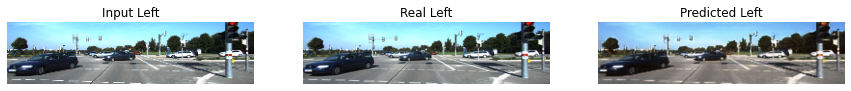

-------- psnr:  22.52029    ----- epoch:  1   count:  100
-------- psnr:  22.623276    ----- epoch:  2   count:  100
tf.Tensor(22.623276, shape=(), dtype=float32)


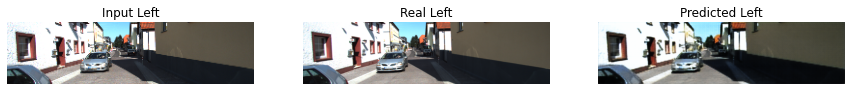

-------- psnr:  22.324366    ----- epoch:  3   count:  100
-------- psnr:  22.644758    ----- epoch:  4   count:  100
tf.Tensor(22.644758, shape=(), dtype=float32)


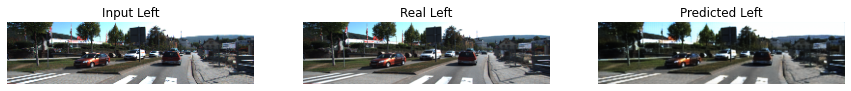

-------- psnr:  22.214756    ----- epoch:  5   count:  100
-------- psnr:  22.787683    ----- epoch:  6   count:  100
tf.Tensor(22.787683, shape=(), dtype=float32)


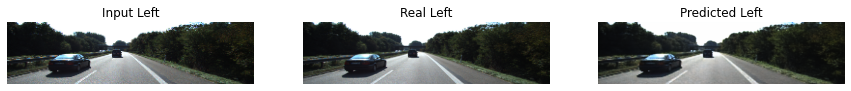

-------- psnr:  22.782303    ----- epoch:  7   count:  100
-------- psnr:  22.60639    ----- epoch:  8   count:  100
-------- psnr:  22.613413    ----- epoch:  9   count:  100


In [ ]:
EPOCHS = 10
fit(train_dataset, EPOCHS, test_dataset)

-------- psnr:  22.548733    ----- epoch:  0   count:  100
tf.Tensor(22.548733, shape=(), dtype=float32)


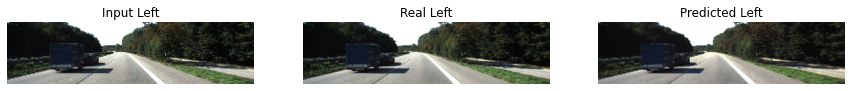

-------- psnr:  22.710005    ----- epoch:  1   count:  100
tf.Tensor(22.710005, shape=(), dtype=float32)


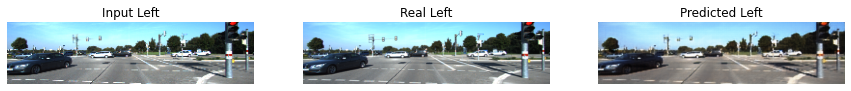

-------- psnr:  22.928225    ----- epoch:  2   count:  100
tf.Tensor(22.928225, shape=(), dtype=float32)


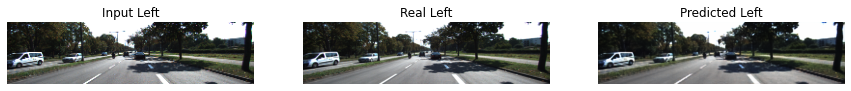

-------- psnr:  22.766665    ----- epoch:  3   count:  100
-------- psnr:  22.796448    ----- epoch:  4   count:  100
-------- psnr:  22.951746    ----- epoch:  5   count:  100
tf.Tensor(22.951746, shape=(), dtype=float32)


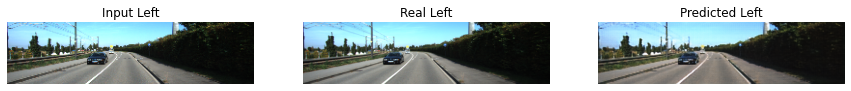

-------- psnr:  22.72472    ----- epoch:  6   count:  100
-------- psnr:  22.872166    ----- epoch:  7   count:  100
-------- psnr:  23.038841    ----- epoch:  8   count:  100
tf.Tensor(23.038841, shape=(), dtype=float32)


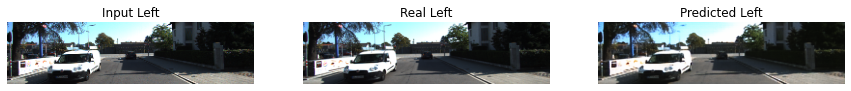

-------- psnr:  22.964554    ----- epoch:  9   count:  100


In [ ]:
EPOCHS = 10
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/My Drive/data/unet/supr_9.h5')

# Show the model architecture
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 256, 3)] 0                                            
__________________________________________________________________________________________________
sequential_22 (Sequential)      (None, 64, 256, 64)  1984        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_23 (Sequential)      (None, 32, 128, 64)  65792       sequential_22[0][0]              
__________________________________________________________________________________________________
sequential_24 (Sequential)      (None, 16, 64, 256)  263168      sequential_23[0][0]              
____________________________________________________________________________________________

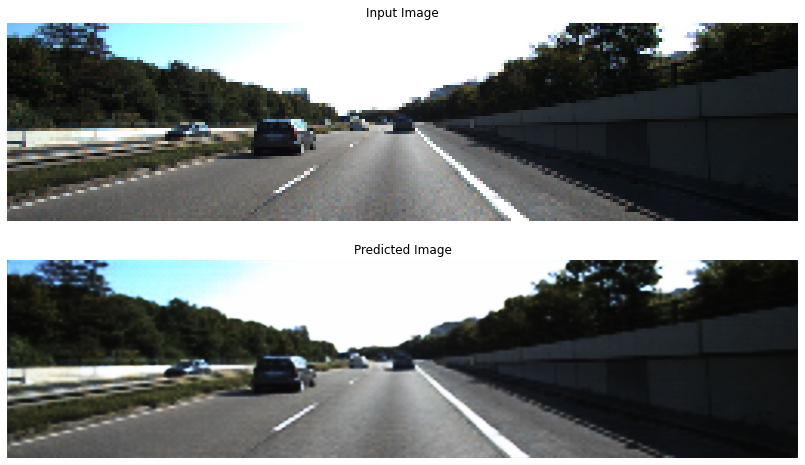

In [ ]:
for inp, tar in test_dataset.take(1):
  fake = generator([inp], training=True)
  plt.figure(figsize=(15,8))
  

  display_list = [inp[0], fake[0]]
  title = ['Input Image', 'Predicted Image']    

  for i in range(2):
      plt.subplot(2, 1, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(lr_img, hr_img):
    with tf.GradientTape() as gen_tape:
        fake_hr = generator([lr_img], training=True)
        loss = compute_loss(fake_hr, hr_img)

    gradients = gen_tape.gradient(loss, generator.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    
    return loss    
    
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        for lr_img, hr_img in train_ds:
           loss = train_step(lr_img, hr_img)